In [1]:
import numpy as np
import mdtraj as md 
import deeptime
from deeptime.decomposition import TICA
from itertools import combinations
import matplotlib.pyplot as plt

from glob import glob

In [2]:
Temperatures = [280,283,286,289,292,295,298,301,304,307,310,313,316,320,323,326,330,333,336,340,343,347,350,354,358,361,365,369,372,376,380,384,388,392,396,400]

pos_path = '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_all/coords_nowater'

## ATTENTION 
In this program lagtime is the same for all the model and a priori assigned. this is not correct in principle and not always valid: need to be checkd for each model

In [3]:
lagtime = 90

In [4]:
tica_projections = []

for T in Temperatures:

    distances = []
    coords = []

    coord_fns = sorted(glob(f'{pos_path}/temperature_{T}/coor*'))
    #assert len(coord_fns) == 3744

    # load topology and consider CA resolution
    chig_pdb = md.load("./chi_sys.pdb").remove_solvent()

    ca_idx = chig_pdb.topology.select("name CA")

    assert len(ca_idx) == 10

    for fn in coord_fns:
        coords = np.load(fn) / 10.0
        aa_pdb = md.Trajectory(xyz=coords, topology=chig_pdb.topology, time=np.arange(len(coords)))
        cg_pdb = aa_pdb.atom_slice(ca_idx)
        ca_atoms = cg_pdb.topology.select("name CA")
        ca_atom_pairs = list(combinations(ca_atoms, 2))

        distances_fn = md.compute_distances(cg_pdb, ca_atom_pairs)
        distances.append(distances_fn)


    all_distances = np.concatenate(distances)

    chosen_tica = TICA(lagtime=lagtime, dim=2, scaling='kinetic_map')

    tica_projections.append(chosen_tica.fit_transform(all_distances))

    print(f'Processed temperature {T}')
    

Processed temperature 280
Processed temperature 283
Processed temperature 286
Processed temperature 289
Processed temperature 292
Processed temperature 295
Processed temperature 298
Processed temperature 301
Processed temperature 304
Processed temperature 307
Processed temperature 310
Processed temperature 313
Processed temperature 316
Processed temperature 320
Processed temperature 323
Processed temperature 326
Processed temperature 330
Processed temperature 333
Processed temperature 336
Processed temperature 340
Processed temperature 343
Processed temperature 347
Processed temperature 350
Processed temperature 354
Processed temperature 358
Processed temperature 361
Processed temperature 365
Processed temperature 369
Processed temperature 372
Processed temperature 376
Processed temperature 380
Processed temperature 384
Processed temperature 388
Processed temperature 392
Processed temperature 396
Processed temperature 400


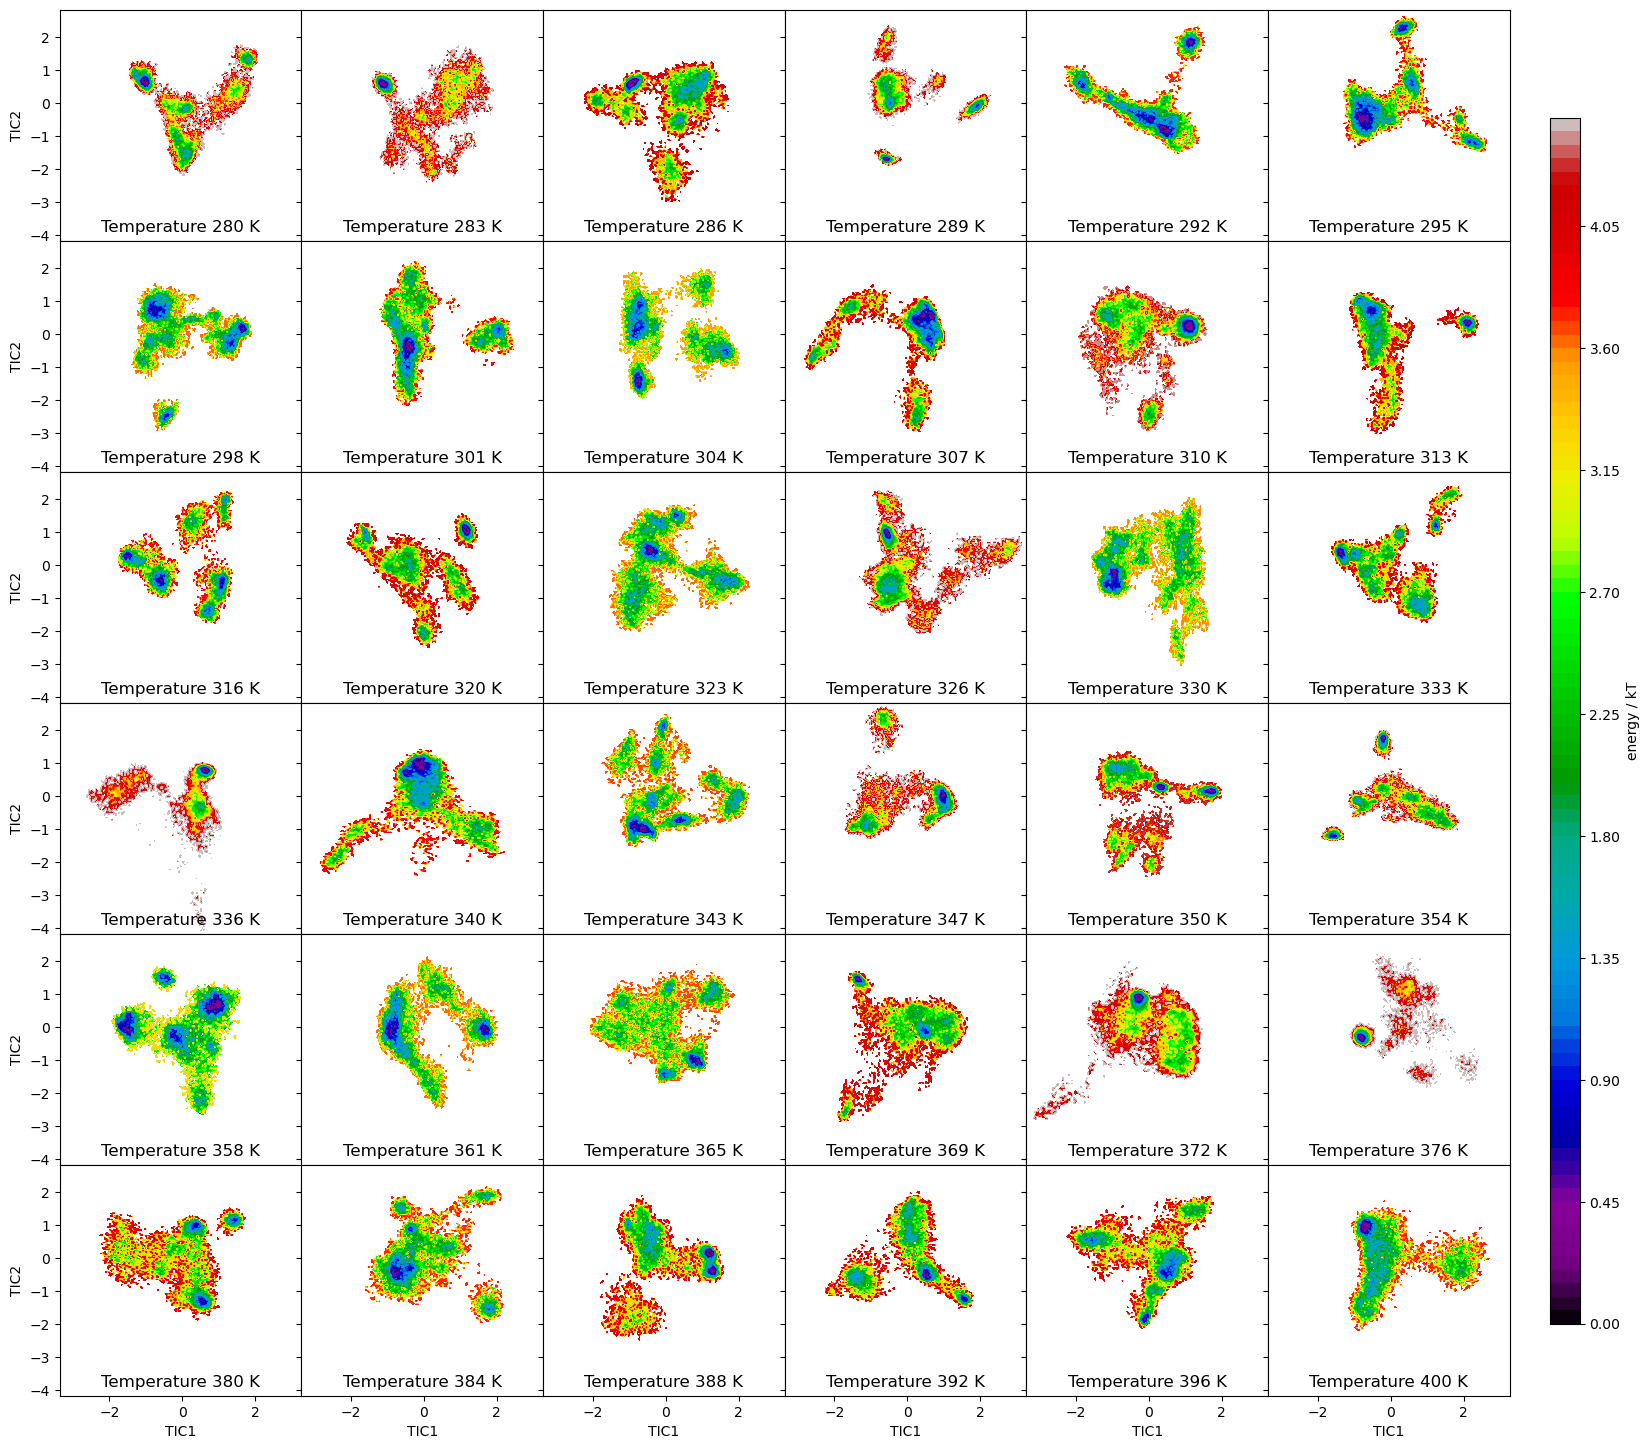

In [16]:
fig, axs = plt.subplots(6,6, sharex=True, sharey=True, figsize=(20,18), gridspec_kw={'hspace': 0, 'wspace': 0})

# Set tiotle position inside the pictures 
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -160  # pad is in points...

k = 0
levels = None
for i in range(6):
    for j in range(6):
        energy_landscape = deeptime.util.energy2d(*tica_projections[k].T, kbt=1.0, shift_energy=True)
        

        # make sure all the scale are the same of the initial one
        if k == 0:
            levels = 100
        else:
            levels = contour.levels
        
        ax, contour, bar = energy_landscape.plot(contourf_kws=dict(cmap='nipy_spectral'), ax=axs[i,j], cbar=False, levels=levels)
        ax.set_title(f'Temperature {Temperatures[k]} K')
        if j == 0:
            ax.set_ylabel('TIC2')
        if i == 5:
            ax.set_xlabel('TIC1')
        
        
        k+=1

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.67])
fig.colorbar(contour, cax=cbar_ax,label= 'energy / kT')
#fig.colorbar.set_label('energy / kT')

plt.show()
